### Achilles Edwin Alfred Saxby
### aes807
### TIME SERIES ANALYSIS
### Goal: Find outliers, trends and periodicity in the MTA turnstile data
#### Collaborated and worked with:
    - Shalmali Kulkarni
    - Christian Rosado
    - Pooneh Famili

#### ----------------------------------------------------------------------------------------------------------------------------------------------

In [191]:
import numpy as np
import pandas as pd
import pylab as pl
import matplotlib
import matplotlib.pyplot as plt
import statsmodels as sm
import statsmodels.formula.api as smf
import statsmodels.api as sma
import seaborn as sns
import numpy.linalg as linalg

from __future__ import print_function
from numpy import random
from scipy import stats
from statsmodels.graphics.api import abline_plot
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

import warnings
import patsy
import operator
import subprocess
import calendar

from datetime import datetime
from IPython.display import Image

%pylab inline

warnings.simplefilter('ignore')

Populating the interactive namespace from numpy and matplotlib


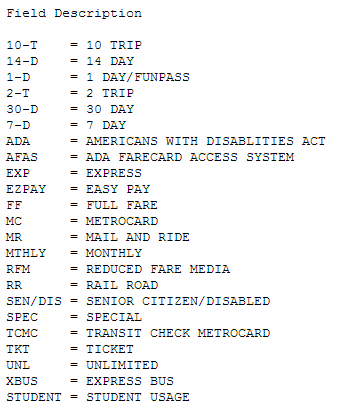

In [3]:
Image(filename = "Ridetypes.png")

#### Each time series (per station, per ticket type) contains the number of swipes per week.
#### This constitutes for 194 weeks from 05/21/2010 to 02/21/2014. 

The data is available as a *python data cube*. 
The data can be loaded as 
```
np.load(“MTA_Fare.npy")
```

In [4]:
data_MTA = np.load("MTA_Fare.npy")
type(data_MTA)

numpy.ndarray

Loading it we end up with a python numpy array of shape (600, 23, 194)

In [5]:
data_MTA = np.where(data_MTA != -1, data_MTA, 'NaN')
data_MTA.shape

(600, 23, 194)

In [6]:
data_MTA

array([[['56961', '64703', '68002', ..., '36527', '33929', '36824'],
        ['1732', '2083', '2107', ..., '1264', '1172', '1238'],
        ['203', '276', '245', ..., '186', '167', '167'],
        ..., 
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['NaN', 'NaN', 'NaN', ..., '1121', '1377', '712']],

       [['16210', '20179', '21769', ..., 'NaN', 'NaN', 'NaN'],
        ['503', '647', '665', ..., 'NaN', 'NaN', 'NaN'],
        ['41', '43', '44', ..., 'NaN', 'NaN', 'NaN'],
        ..., 
        ['0', '0', '0', ..., 'NaN', 'NaN', 'NaN'],
        ['0', '0', '0', ..., 'NaN', 'NaN', 'NaN'],
        ['NaN', 'NaN', 'NaN', ..., 'NaN', 'NaN', 'NaN']],

       [['3292', '3429', '3629', ..., '3746', '3406', '3217'],
        ['110', '92', '102', ..., '212', '209', '211'],
        ['7', '6', '13', ..., '26', '20', '22'],
        ..., 
        ['0', '0', '0', ..., '0', '0', '0'],
        ['0', '0', '0', ..., '0', '0', '0'],
        ['NaN', 'NaN', 'N

#### ----------------------------------------------------------------------------------------------------------------------------------------------

### Task 1: 
#### Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.

In [7]:
mta_data = data_MTA.astype(float)

#### Sum up all 23 different ridership by stations and time.

In [8]:
mta1 = np.nansum(mta_data, axis=1, dtype=None, out=None, keepdims=0)
mta1.shape

(600, 194)

In [9]:
mta2 = mta1.transpose()
mta2.shape

(194, 600)

#### Convertign the array to a dataframe

In [10]:
MTAData = pd.DataFrame(mta2)

In [11]:
dates = pd.date_range(start = '06/04/2010', end = '02/14/2014', freq = '7D')
len(dates)

194

- Frequency = 'W' could not be used because it then deducts the first week and the total tally comes upto 193 only
- Using '7D' the weeks are 194

In [41]:
MTAData.index = pd.Index(dates)

In [13]:
MTAData.head()

0        1       2        3        4        5        6    \
2010-06-04  126878.0  37306.0  6606.0  16378.0  18564.0  19987.0  12449.0   
2010-06-11  149477.0  46464.0  6881.0  17408.0  19903.0  20625.0  13644.0   
2010-06-18  152383.0  49359.0  7229.0  17595.0  19948.0  21225.0  13719.0   
2010-06-25  160175.0  44849.0  5731.0  14242.0  16076.0  17412.0  11460.0   
2010-07-02  162641.0  41509.0  7032.0  17589.0  20283.0  20909.0  14094.0   

                7        8         9   ...   590  591  592  593  594  595  \
2010-06-04  11091.0  10482.0  147187.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-11  11659.0  11030.0  154826.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-18  12037.0  10881.0  155958.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-25   9809.0   9123.0  154914.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-07-02  11944.0  10923.0  157628.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   

            596  597  598  599  
2010-06-04  0.0  0.0  0.0  0.0  
2010-06-11  0.0  0.0  0.0  0.0  
2010-06-18  0.0  0.0  0.0  0.0  
2010-06-25  0.0  0.0  0.0  0.0  
2010-07-02  0.0  0.0  0.0  0.0  

[5 rows x 600 columns]

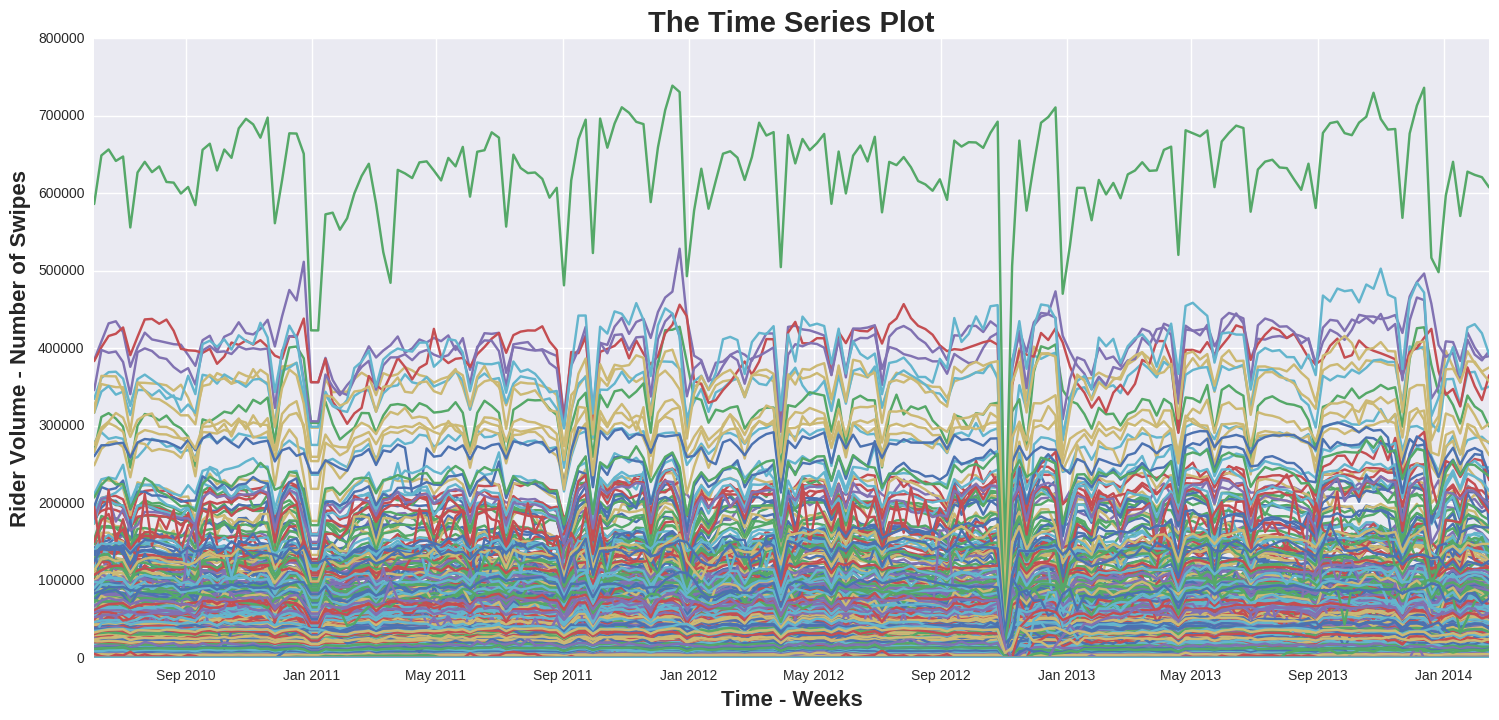

In [40]:
plt.figure(figsize=(18,8))
pl.plot(MTAData.index, MTAData)
pl.xlabel("Time - Weeks", fontsize=16, fontweight = 'bold')
pl.ylabel("Rider Volume - Number of Swipes", fontsize=16, fontweight = 'bold')
pl.title("The Time Series Plot", fontsize=21, fontweight = 'bold')

#### Figure 1 : The figure above is a representation of the data collected, cleaned, merged and plotted for the time-series analysis of the Riders v/s Time in relation to the MTA turnstyle data. 
- The time series plot for the number of swipes/rider volume and the time in weeks has been plotted above.
- Even though the plot looks like it is in a mess and there is nothing much to read or look at in the data.
- It can be observed that there are some ridges or some drops in certain areas of the plot.
- It can also be observed that there is a major drop in the data somewhere between Sep'2012 - Jan'2013 but we will need to clean up the plot before the conclusion can be made for sure.

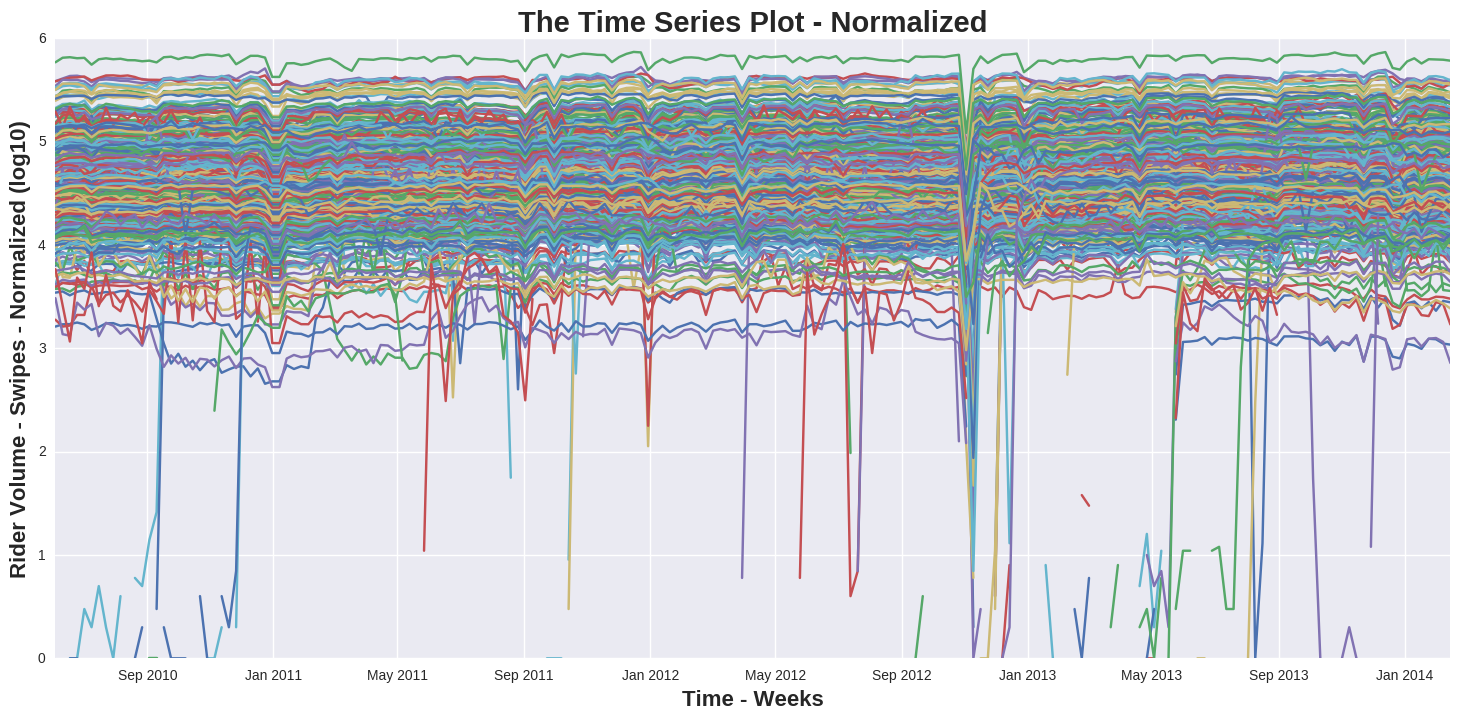

In [39]:
plt.figure(figsize=(18,8))
pl.plot(MTAData.index, np.log10(MTAData))
pl.xlabel("Time - Weeks", fontsize=16, fontweight = 'bold')
pl.ylabel("Rider Volume - Swipes - Normalized (log10)", fontsize=16, fontweight = 'bold')
pl.title("The Time Series Plot - Normalized", fontsize=21, fontweight = 'bold')

#### Figure 2 : The figure above is a representation of the MTA turnstyle data after normalizing the Rider-Volume so as to get a better visualization and representation. 
- It can now be made out that there exist some significant drops in certain areas of the plot.
- The Time Series here is normalized in regards to the rider volume in log space.

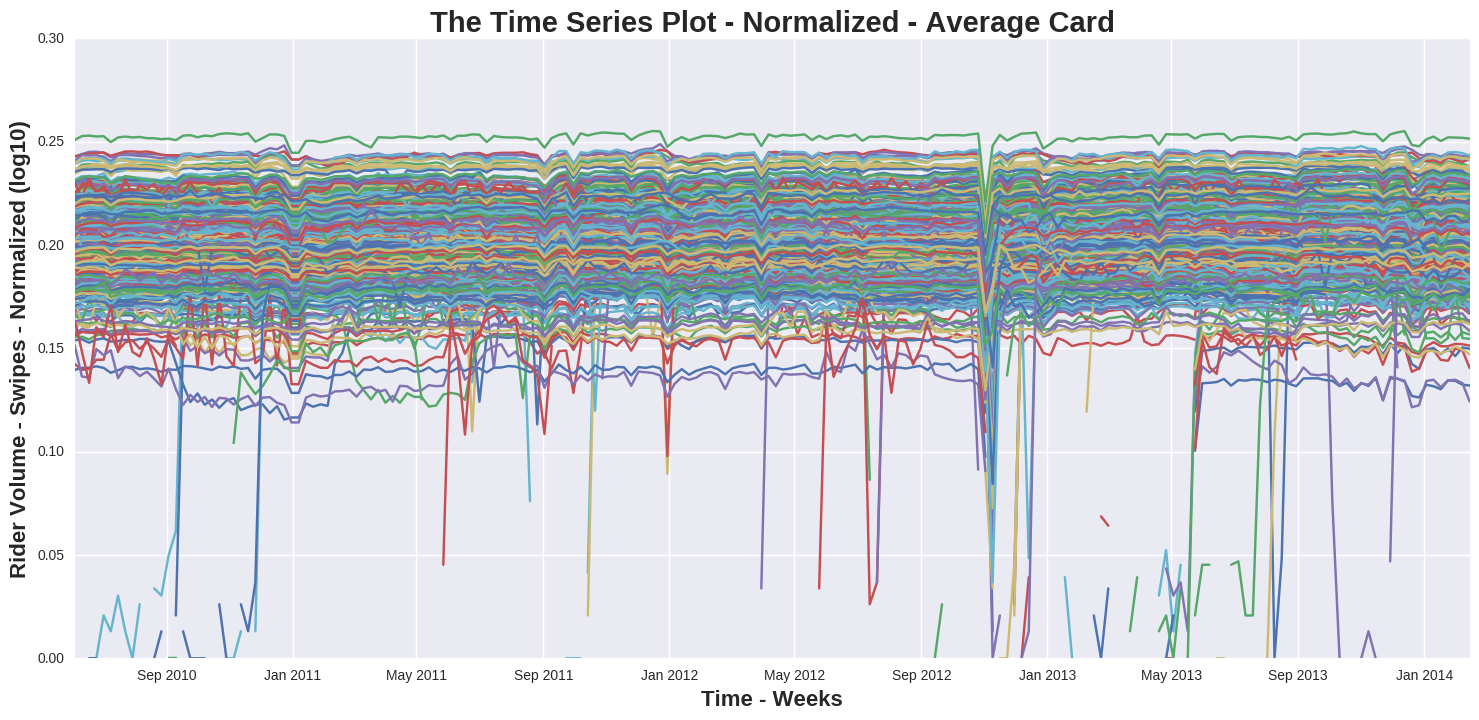

In [38]:
plt.figure(figsize=(18,8))
pl.plot(MTAData.index, np.log10(MTAData)/23)
pl.xlabel("Time - Weeks", fontsize=16, fontweight = 'bold')
pl.ylabel("Rider Volume - Swipes - Normalized (log10)", fontsize=16, fontweight = 'bold')
pl.title("The Time Series Plot - Normalized - Average Card", fontsize=21, fontweight = 'bold')

#### Figure 3 : The figure above is a representation of the MTA turnstyle data after normalizing the Rider-Volume so as to get a better visualization and representation and averaging out the different card types.
- The Time Series here is normalized in regards to the rider volume in log space.
- The Rider Volume after normalization has also been divinded by the different card types - 23 to be precise so as to minimize the variation in different card types and only focus on the card as one single entity.

#### Sum all the ridership from 600 stations in one time-series.

In [23]:
MTAD_1 = np.nansum(MTAData, axis=1, dtype=None, out=None, keepdims=0)
MTAD_1.shape

(194,)

#### Converting the array into a dataframe.

In [25]:
MTAD_1 = pd.DataFrame(MTAD_1)
MTAD_1

0
0    26720267.0
1    29265971.0
2    29601189.0
3    29387592.0
4    29185768.0
5    26211666.0
6    28683614.0
7    29125646.0
8    28803814.0
9    28599546.0
10   28312019.0
11   27931015.0
12   27271701.0
13   28250357.0
14   26687174.0
15   30018756.0
16   30183790.0
17   29052100.0
18   30068614.0
19   29172431.0
20   30327068.0
21   30190292.0
22   29987273.0
23   30053446.0
24   30128994.0
25   25164391.0
26   29189219.0
27   30580790.0
28   30106591.0
29   27561217.0
..          ...
164  31060069.0
165  30672288.0
166  30477105.0
167  29658260.0
168  29941845.0
169  27830794.0
170  33157649.0
171  33538567.0
172  33827121.0
173  33481314.0
174  33486842.0
175  32752123.0
176  34071477.0
177  33845862.0
178  33947696.0
179  33020492.0
180  33485463.0
181  27372991.0
182  33173670.0
183  34058171.0
184  33808622.0
185  24806944.0
186  24851491.0
187  30328635.0
188  31366089.0
189  28575616.0
190  31715761.0
191  31818560.0
192  30954425.0
193  29535321.0

[194 rows x 1 columns]

#### Segregating it for the time period in question.

In [27]:
MTAD_1.index = pd.Index(dates)
MTAD_1.index

DatetimeIndex(['2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25',
               '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23',
               '2010-07-30', '2010-08-06',
               ...
               '2013-12-13', '2013-12-20', '2013-12-27', '2014-01-03',
               '2014-01-10', '2014-01-17', '2014-01-24', '2014-01-31',
               '2014-02-07', '2014-02-14'],
              dtype='datetime64[ns]', length=194, freq='7D')

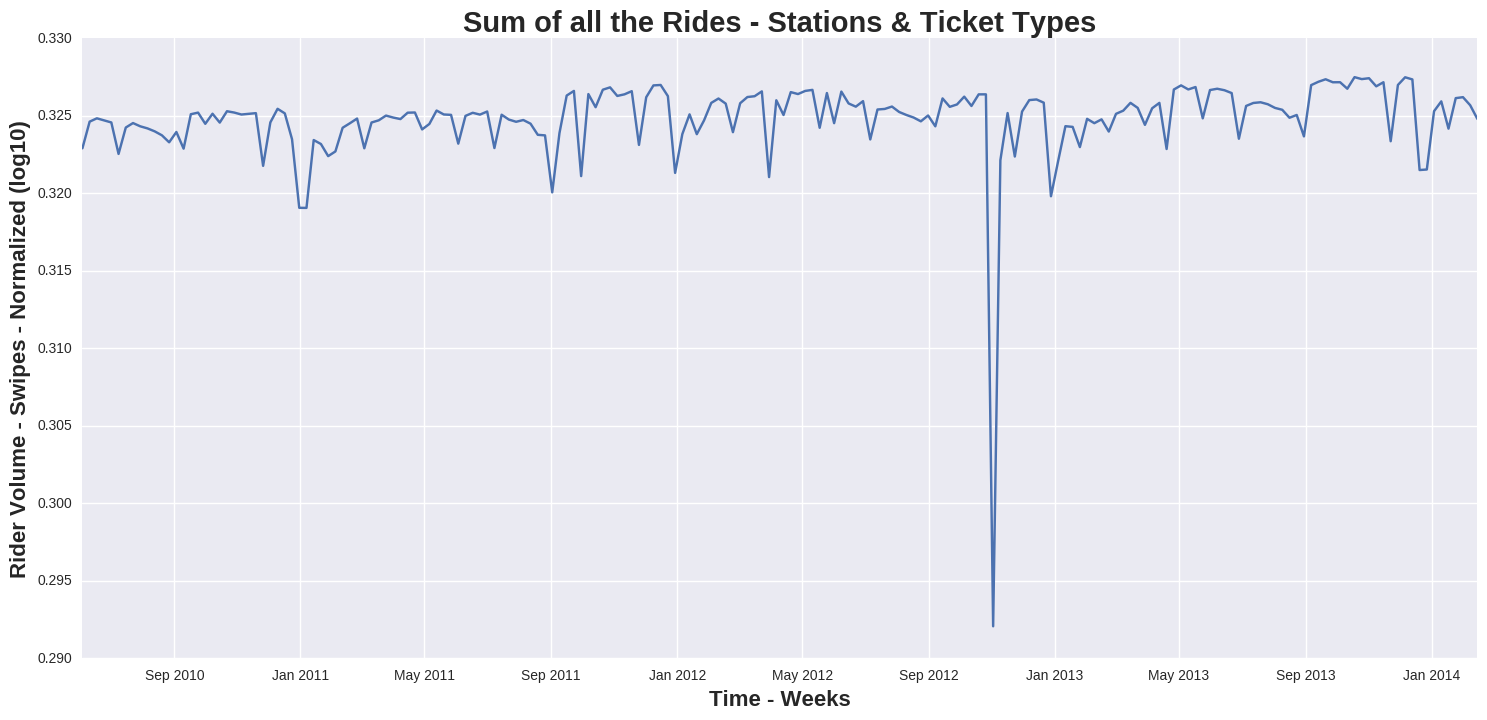

In [37]:
plt.figure(figsize=(18,8))
pl.plot(MTAD_1.index, np.log10(MTAD_1)/23)
pl.xlabel("Time - Weeks", fontsize=16, fontweight = 'bold')
pl.ylabel("Rider Volume - Swipes - Normalized (log10)", fontsize=16, fontweight = 'bold')
pl.title("Sum of all the Rides - Stations & Ticket Types", fontsize=21, fontweight = 'bold')

#### Figure 4: The figure above is a representation of the MTA turnstyle data after normalizing the Rider-Volume against the Time in Weeks with the sum of all rides. This plot shows one single huge prominent drops and other drops as well.
- It can be noticed clearly without any confusion, one single time-series plot and one mega-event that shows a humungous drop.
- The Mean and Stardard Deviation of the time-series can be used to set a 3-sigma threshold. 
- Every value that is more then 3 sigma's away from the mean can be flaged as an event.

In [29]:
print ('The mean of the time series is : ', MTAD_1[0].mean())
print ('The standard deviation is :', MTAD_1[0].std())

The mean of the time series is :  29781349.8711
The standard deviation is : 2991680.90141


In [42]:
thresholds = [MTAD_1[0].mean() + (3 * MTAD_1[0].std()), 
              MTAD_1[0].mean() - (3 * MTAD_1[0].std())]

print ('The 3-sigma thresholds are:', thresholds)

The 3-sigma thresholds are: [38756392.57537587, 20806307.166892171]


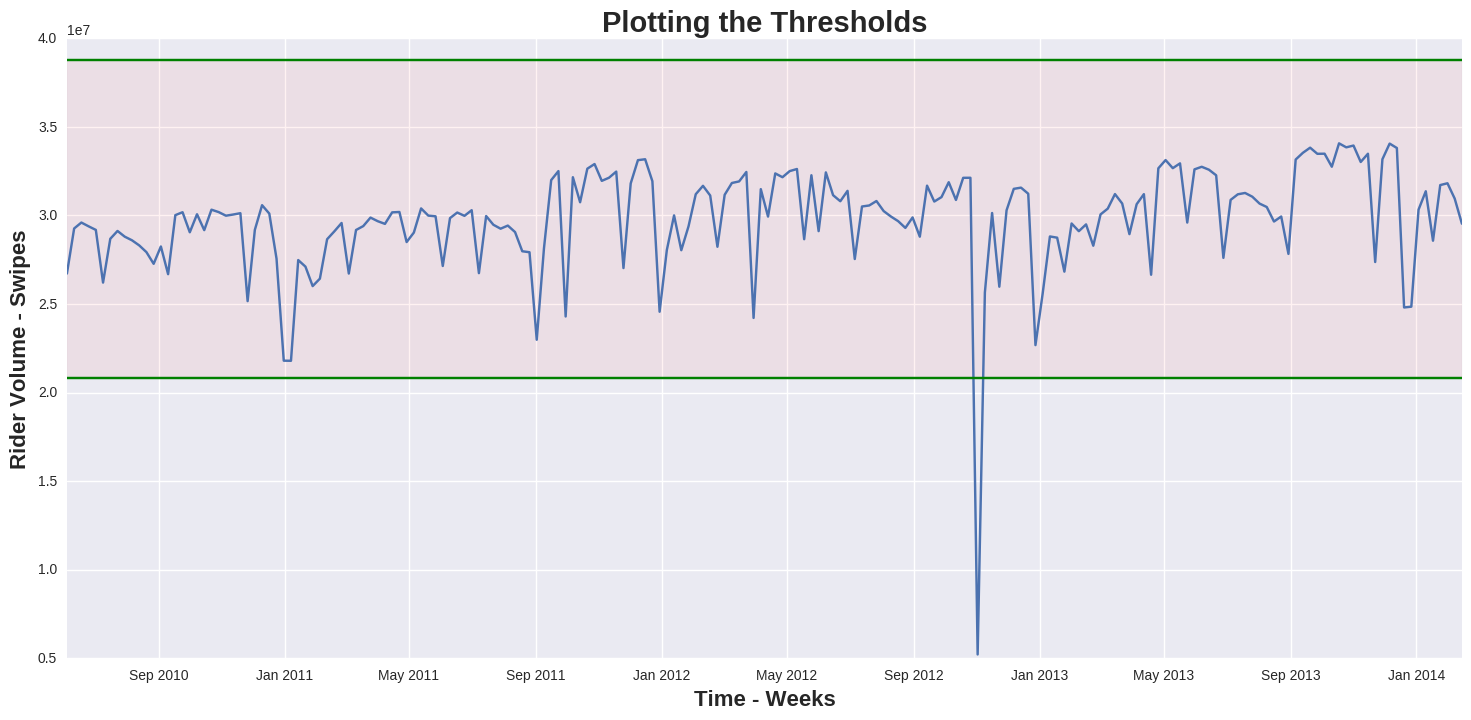

In [43]:
plt.figure(figsize=(18,8))

ax = pl.plot(MTAD_1.index, MTAD_1)

pl.xlabel("Time - Weeks", fontsize=16, fontweight = 'bold')
pl.ylabel("Rider Volume - Swipes", fontsize=16, fontweight = 'bold')
pl.fill_between(MTAD_1.index, thresholds[0], thresholds[1], 
                facecolor='r', alpha=0.05, label="3-sigma Threshold")

plt.axhline(thresholds[0], color='g', linestyle='-')
plt.axhline(thresholds[1], color='g', linestyle='-')

pl.title("Plotting the Thresholds", fontsize=21, fontweight = 'bold')

#### Figure 5: The plot above shows the Maximum and Minimum values for the Thresholds.
- The upper limit and the lower limit of the plot or thresholds here show us the limit for the 3-sigma calculations.
- The same limits also shows the significance of major events that have crossed the 3-sigma value.
- It can be observed that there is one such event that has been recorded here.

### Noticing here that there is a significant drop between Sep 2012 and Jan 2013. 
### The only clear solution is to check the news and other articles that show of a sudden change in that timeline.
### In regards to the research it can be concluded that the reason behind the drop is Hurricane Sandy which hit the area from October 21, 2012 to October 31, 2012.

#### Check the exact date of 126th week

In [45]:
print ('The Date of the Significant Drop: ', MTAD_1.index[126])

The Date of the Significant Drop:  2012-11-02 00:00:00


- Guessing the time series start date - 05/28/2012 instead of 05/21/2012.
- The range can also be created in such a way so as to reveal the data.

In [47]:
Range = pd.date_range('05/28/2010', periods=194, freq='W')
Range = pd.DataFrame(Range)
print ('The Date of the Significant Drop: ', Range.loc[126])

The Date of the Significant Drop:  0   2012-10-28
Name: 126, dtype: datetime64[ns]


#### Results Obtained:
- The significant event detected: Hurricane Sandy
- Total fatalities: 285
- Highest wind speed: 115 mph
- Category: Category 3 Hurricane (SSHS)
- Date: October 22, 2012 – November 2, 2012

#### ----------------------------------------------------------------------------------------------------------------------------------------------

### Task 2: 
#### Some of the time series are stationary, some have a complex structure, some show a downward trend: 
- Identify the **ridership types**  that have steadily increased in popularity, and that have steadily decreased
- By how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)

#### Summing up all 23 different ridership(s) by Stations and Time.

In [51]:
ridetype = ['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud']
MTAD_2 = np.nanmean(mta_data, axis=0, dtype=None, out=None, keepdims=0)
# mta_data = data_MTA converted into "float"

MTAD_2 = MTAD_2.transpose()
MTAD_2.shape

(194, 23)

#### Converting the array into a dataframe:

In [52]:
MTAD_2 = pd.DataFrame(MTAD_2)

#### Since the date range per week for 194 weeks is from 05/28/2010 to 02/21/2014.

In [56]:
MTAD_2.index = pd.Index(dates, freq='7D')
MTAD_2.index

DatetimeIndex(['2010-06-04', '2010-06-11', '2010-06-18', '2010-06-25',
               '2010-07-02', '2010-07-09', '2010-07-16', '2010-07-23',
               '2010-07-30', '2010-08-06',
               ...
               '2013-12-13', '2013-12-20', '2013-12-27', '2014-01-03',
               '2014-01-10', '2014-01-17', '2014-01-24', '2014-01-31',
               '2014-02-07', '2014-02-14'],
              dtype='datetime64[ns]', length=194, freq='7D')

In [57]:
MTAD_2.columns = ridetype
MTAD_2[:5]

10t          14d          1d          2t         30d  \
2010-06-04  24880.119048  1148.320346  103.465368  403.790043  101.316017   
2010-06-11  27173.229935  1265.798265  111.683297  432.167028  139.594360   
2010-06-18  27573.708423  1266.077754  111.524838  431.248380  123.097192   
2010-06-25  27329.751620  1215.123110  112.447084  424.166307   80.840173   
2010-07-02  27607.099138  1182.883621  110.243534  420.006466   75.883621   

                     7d           ada       afas         exp           ez  \
2010-06-04  8003.123377  18510.686147  21.781385  721.205628  1108.294372   
2010-06-11  8637.327549  20577.861171  25.698482  613.351410  1253.845987   
2010-06-18  8710.647948  20467.684665  26.516199  652.328294  1329.453564   
2010-06-25  8710.049676  20410.542117  24.235421  659.855292  1309.438445   
2010-07-02  8460.012931  20030.176724  22.661638  723.663793  1214.323276   

            ...        month          rfm          rr        sen     spec  \
2010-06-04  ...   266.523810  1710.194805  129.456710  61.084416  0.00000   
2010-06-11  ...   329.605206  1969.778742  150.127983  70.136659  0.00000   
2010-06-18  ...   327.295896  1974.349892  150.267819  70.449244  0.00000   
2010-06-25  ...   317.697624  1949.349892  147.082073  69.987041  0.00000   
2010-07-02  ...   297.172414  1843.907328  143.053879  68.821121  0.37931   

                  tcmc          t      umlim      xbus  stud  
2010-06-04  269.898268  45.584416  13.264069  0.774892   NaN  
2010-06-11  264.019523  47.006508  13.275488  1.028200   NaN  
2010-06-18  263.889849  46.291577  14.017279  1.004320   NaN  
2010-06-25  263.609071  46.717063  14.233261  1.045356   NaN  
2010-07-02  258.137931  43.743534  13.605603  0.974138   NaN  

[5 rows x 23 columns]

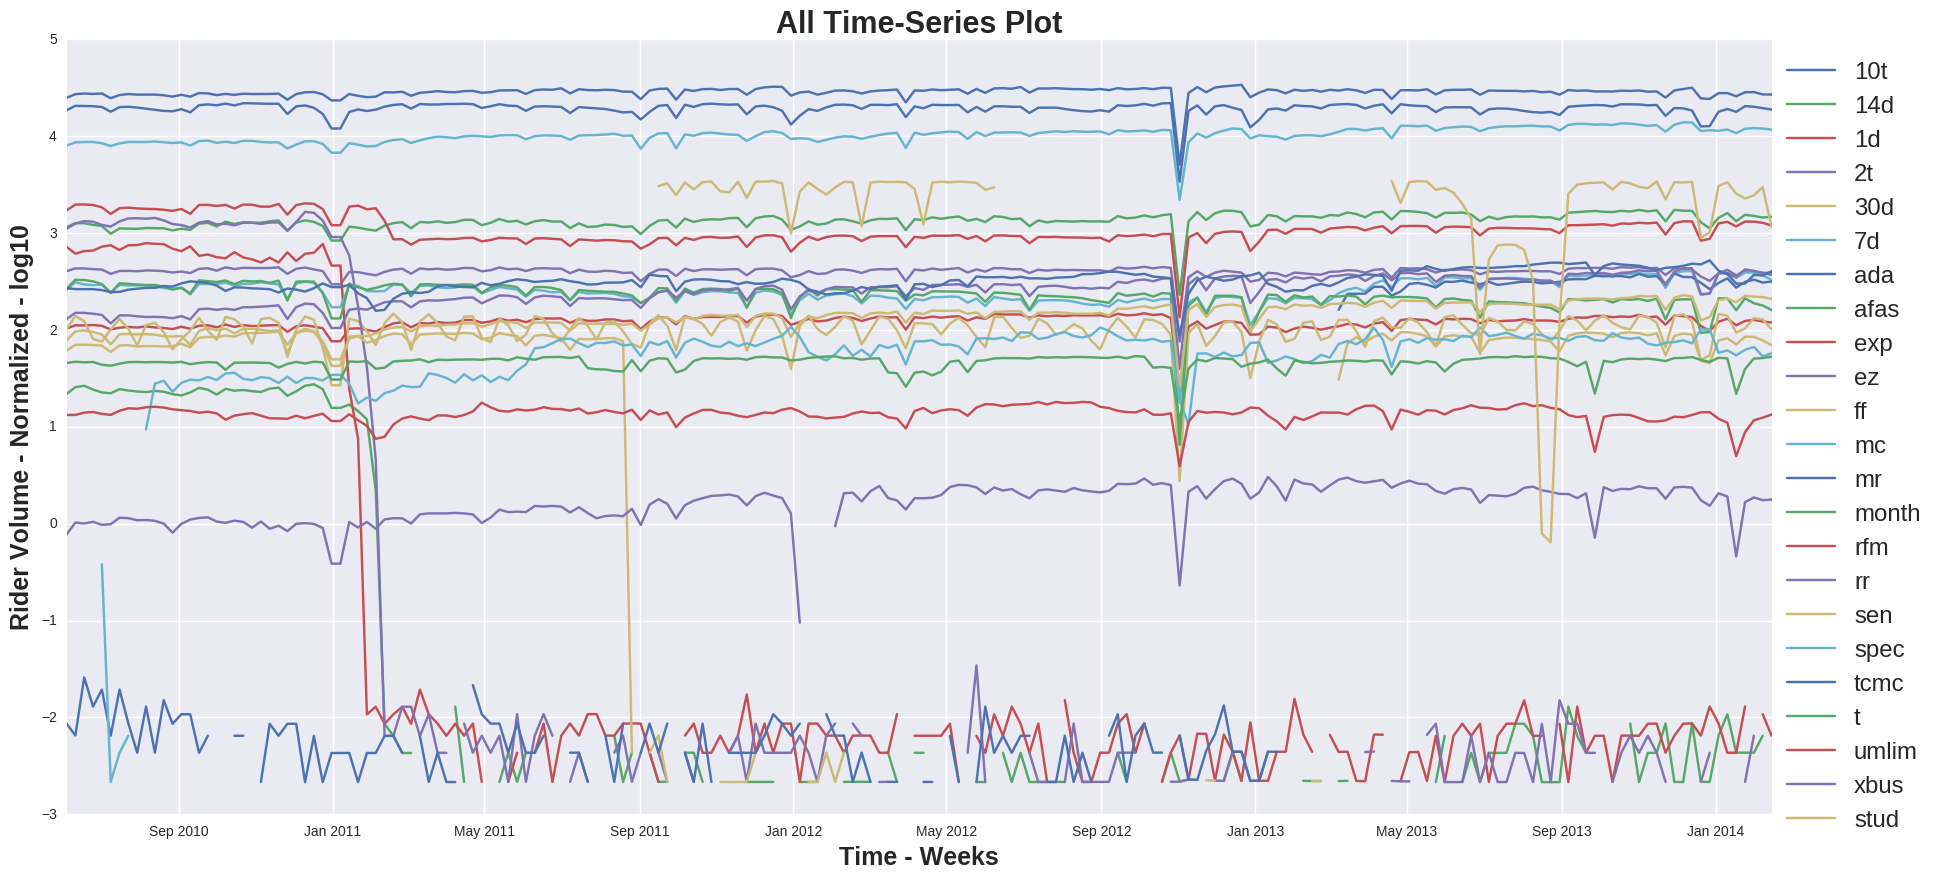

In [83]:
plt.figure(figsize=(22,10))
ax = plt.subplot(111)

pl.plot(MTAD_2.index, np.log10(MTAD_2)) 
pl.xlabel("Time - Weeks", fontsize=18, fontweight = 'bold')
pl.ylabel("Rider Volume - Normalized - log10", fontsize=18, fontweight = 'bold')
pl.title("All Time-Series Plot", fontsize=22, fontweight = 'bold')

ax.legend(MTAD_2.columns, bbox_to_anchor=(1.1, 1), fontsize = 'xx-large')

#### Figure 6: Rider Volume normalized aginst the Time in Weeks.
- The legend here contains all the 23 types of MTA Cards
- On a side note:
    - The Hurricane Sandy dip can be observed

#### Analyzing the Data - Rolling Means

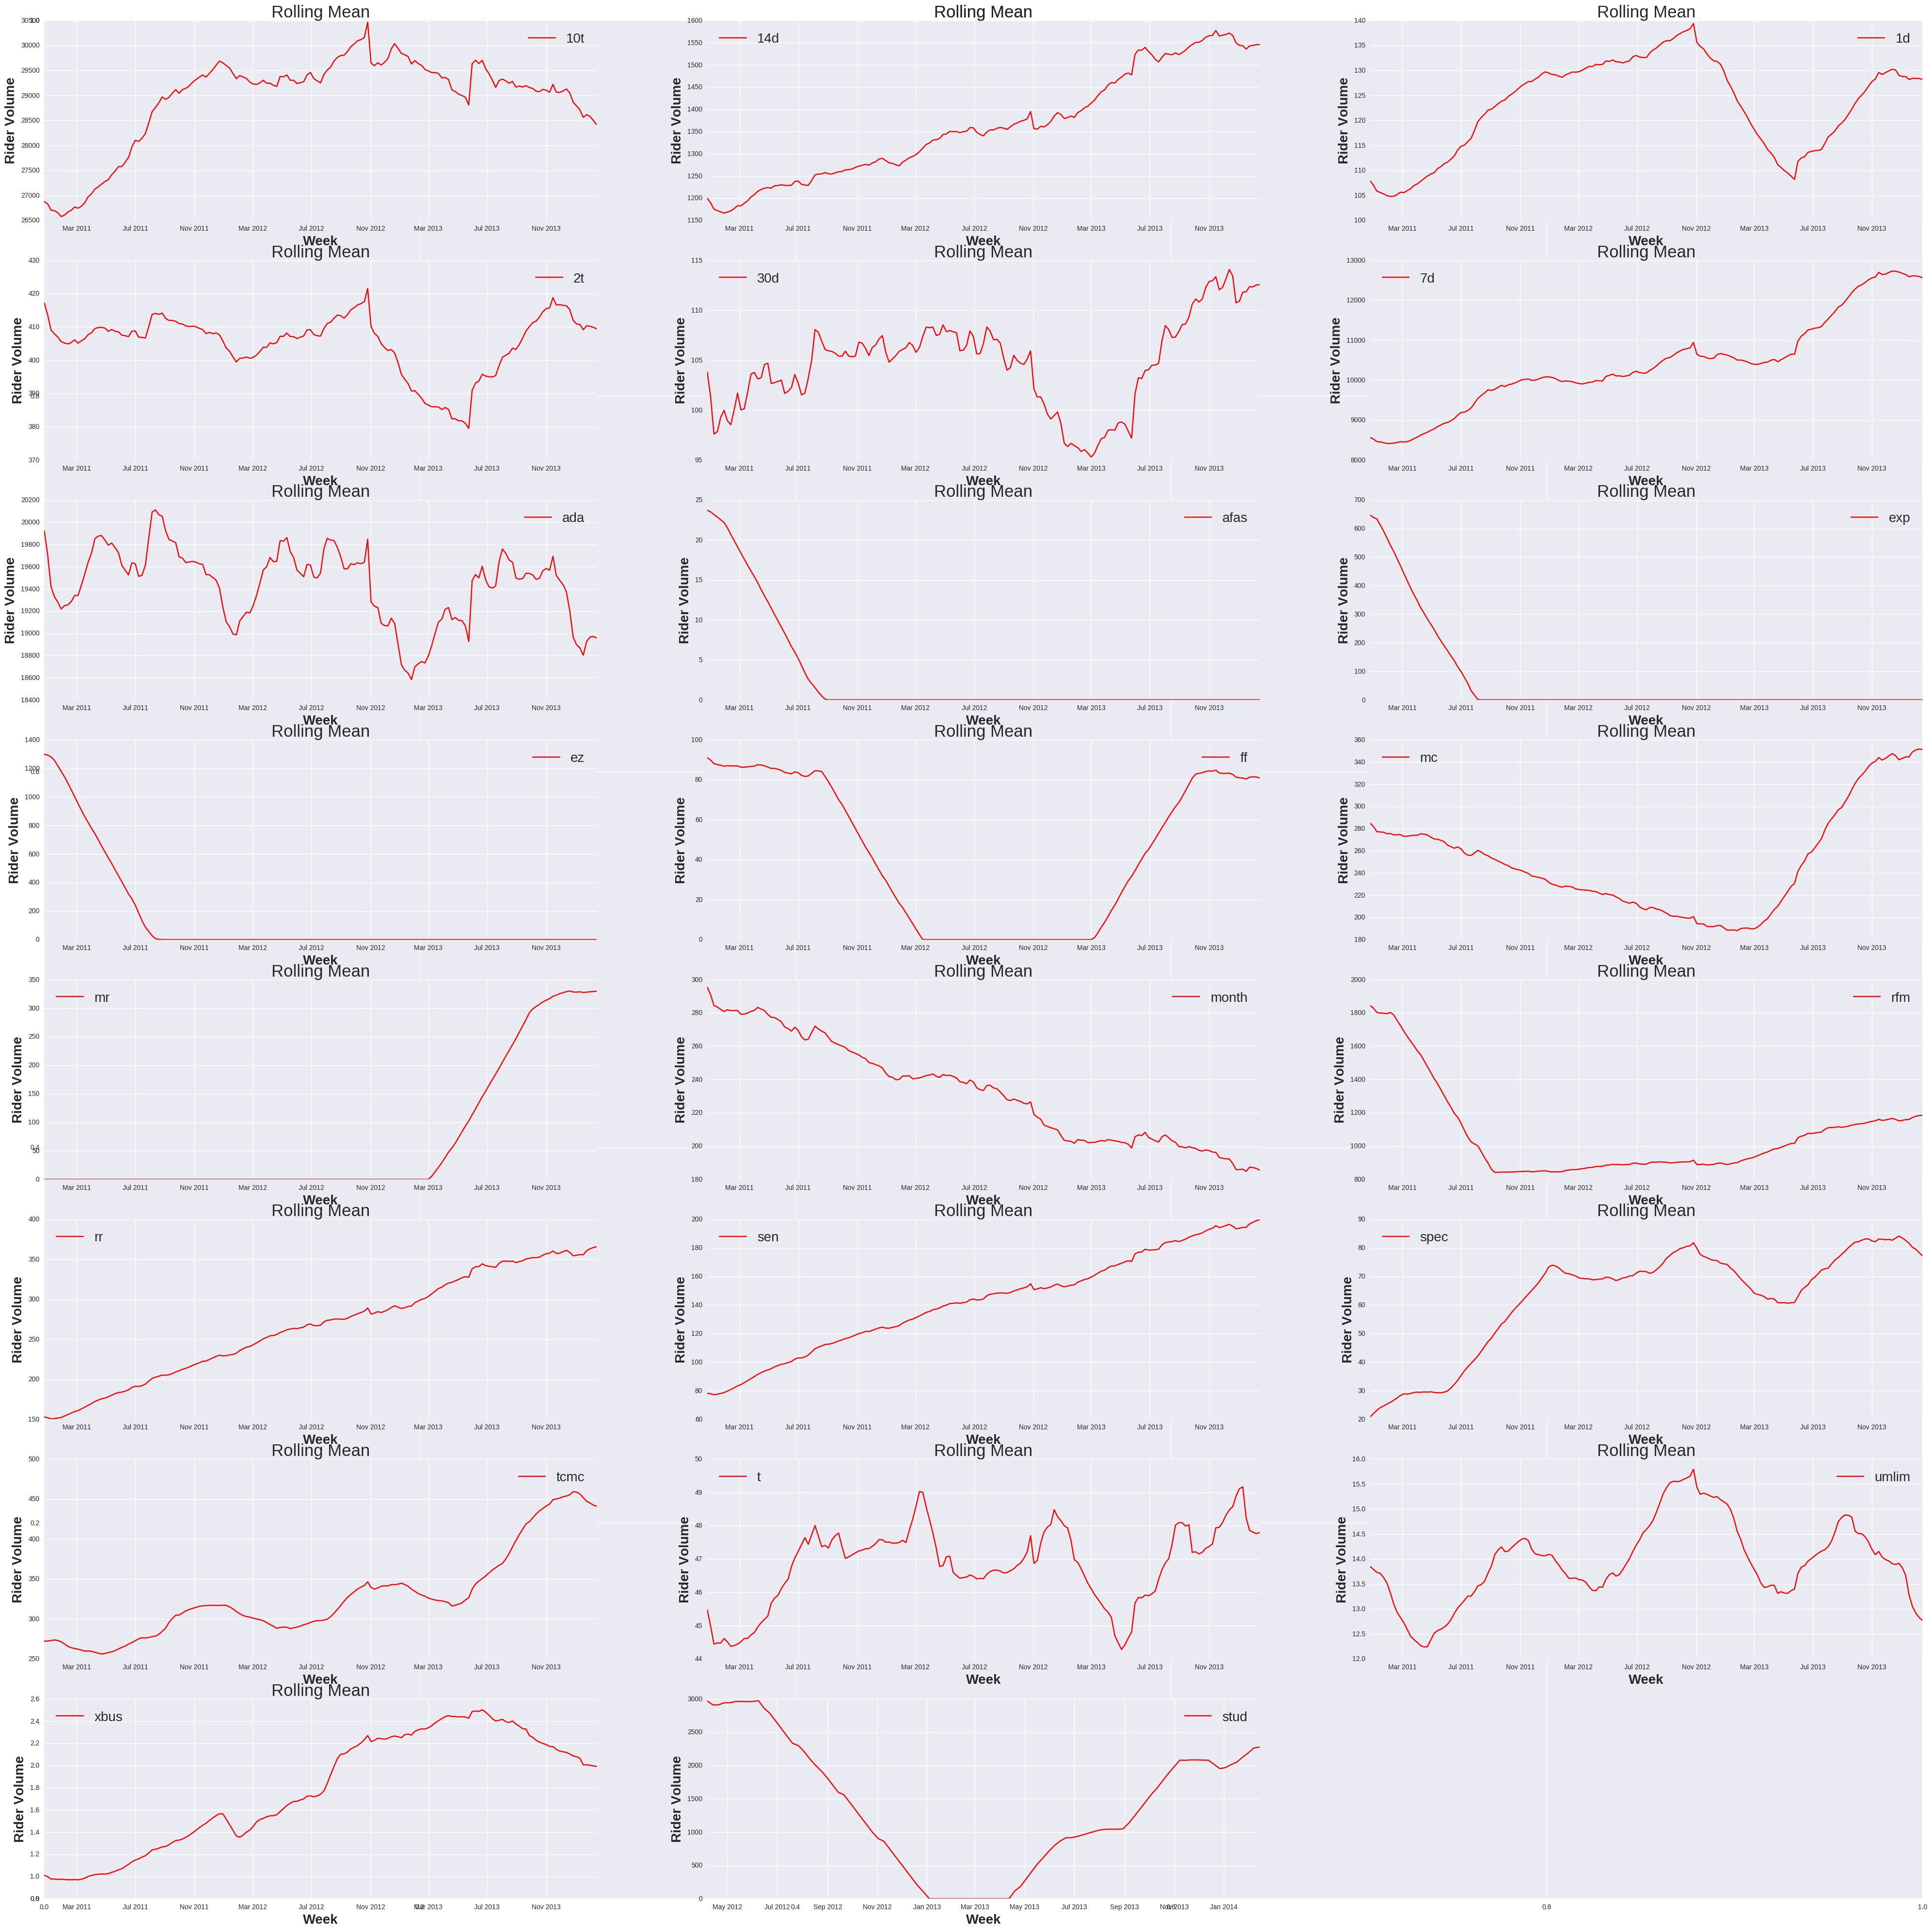

In [101]:
fig = plt.figure(figsize=(50,50)) 
x = 1

for i in ridetype:
    plt.title('Rolling Mean',fontsize = 25)
    mean1 = pd.rolling_mean(MTAD_2[i], 30)
    ax = fig.add_subplot(8,3,x)
    ax.plot(MTAD_2.index, mean1, 'r')
    pl.xlabel("Week", fontsize=20, fontweight = 'bold')
    pl.ylabel("Rider Volume", fontsize=20, fontweight = 'bold')
    pl.legend([i], fontsize = 20, loc = 'best')
    x = x+1  

#### Figure 7: Rolling Mean for every rider type (Numbered 23).
- The plots show only visually either the increase or decrease in trends of the rider types.
- It can be seen that: 
    - 14 day
    - 7 day 
    - Rilroad
    - Senior
    - Special and 
    - Transitcheck Metrocards
    - Expressbus have upward trends 
- Whereas monthly passes have a downward trend.

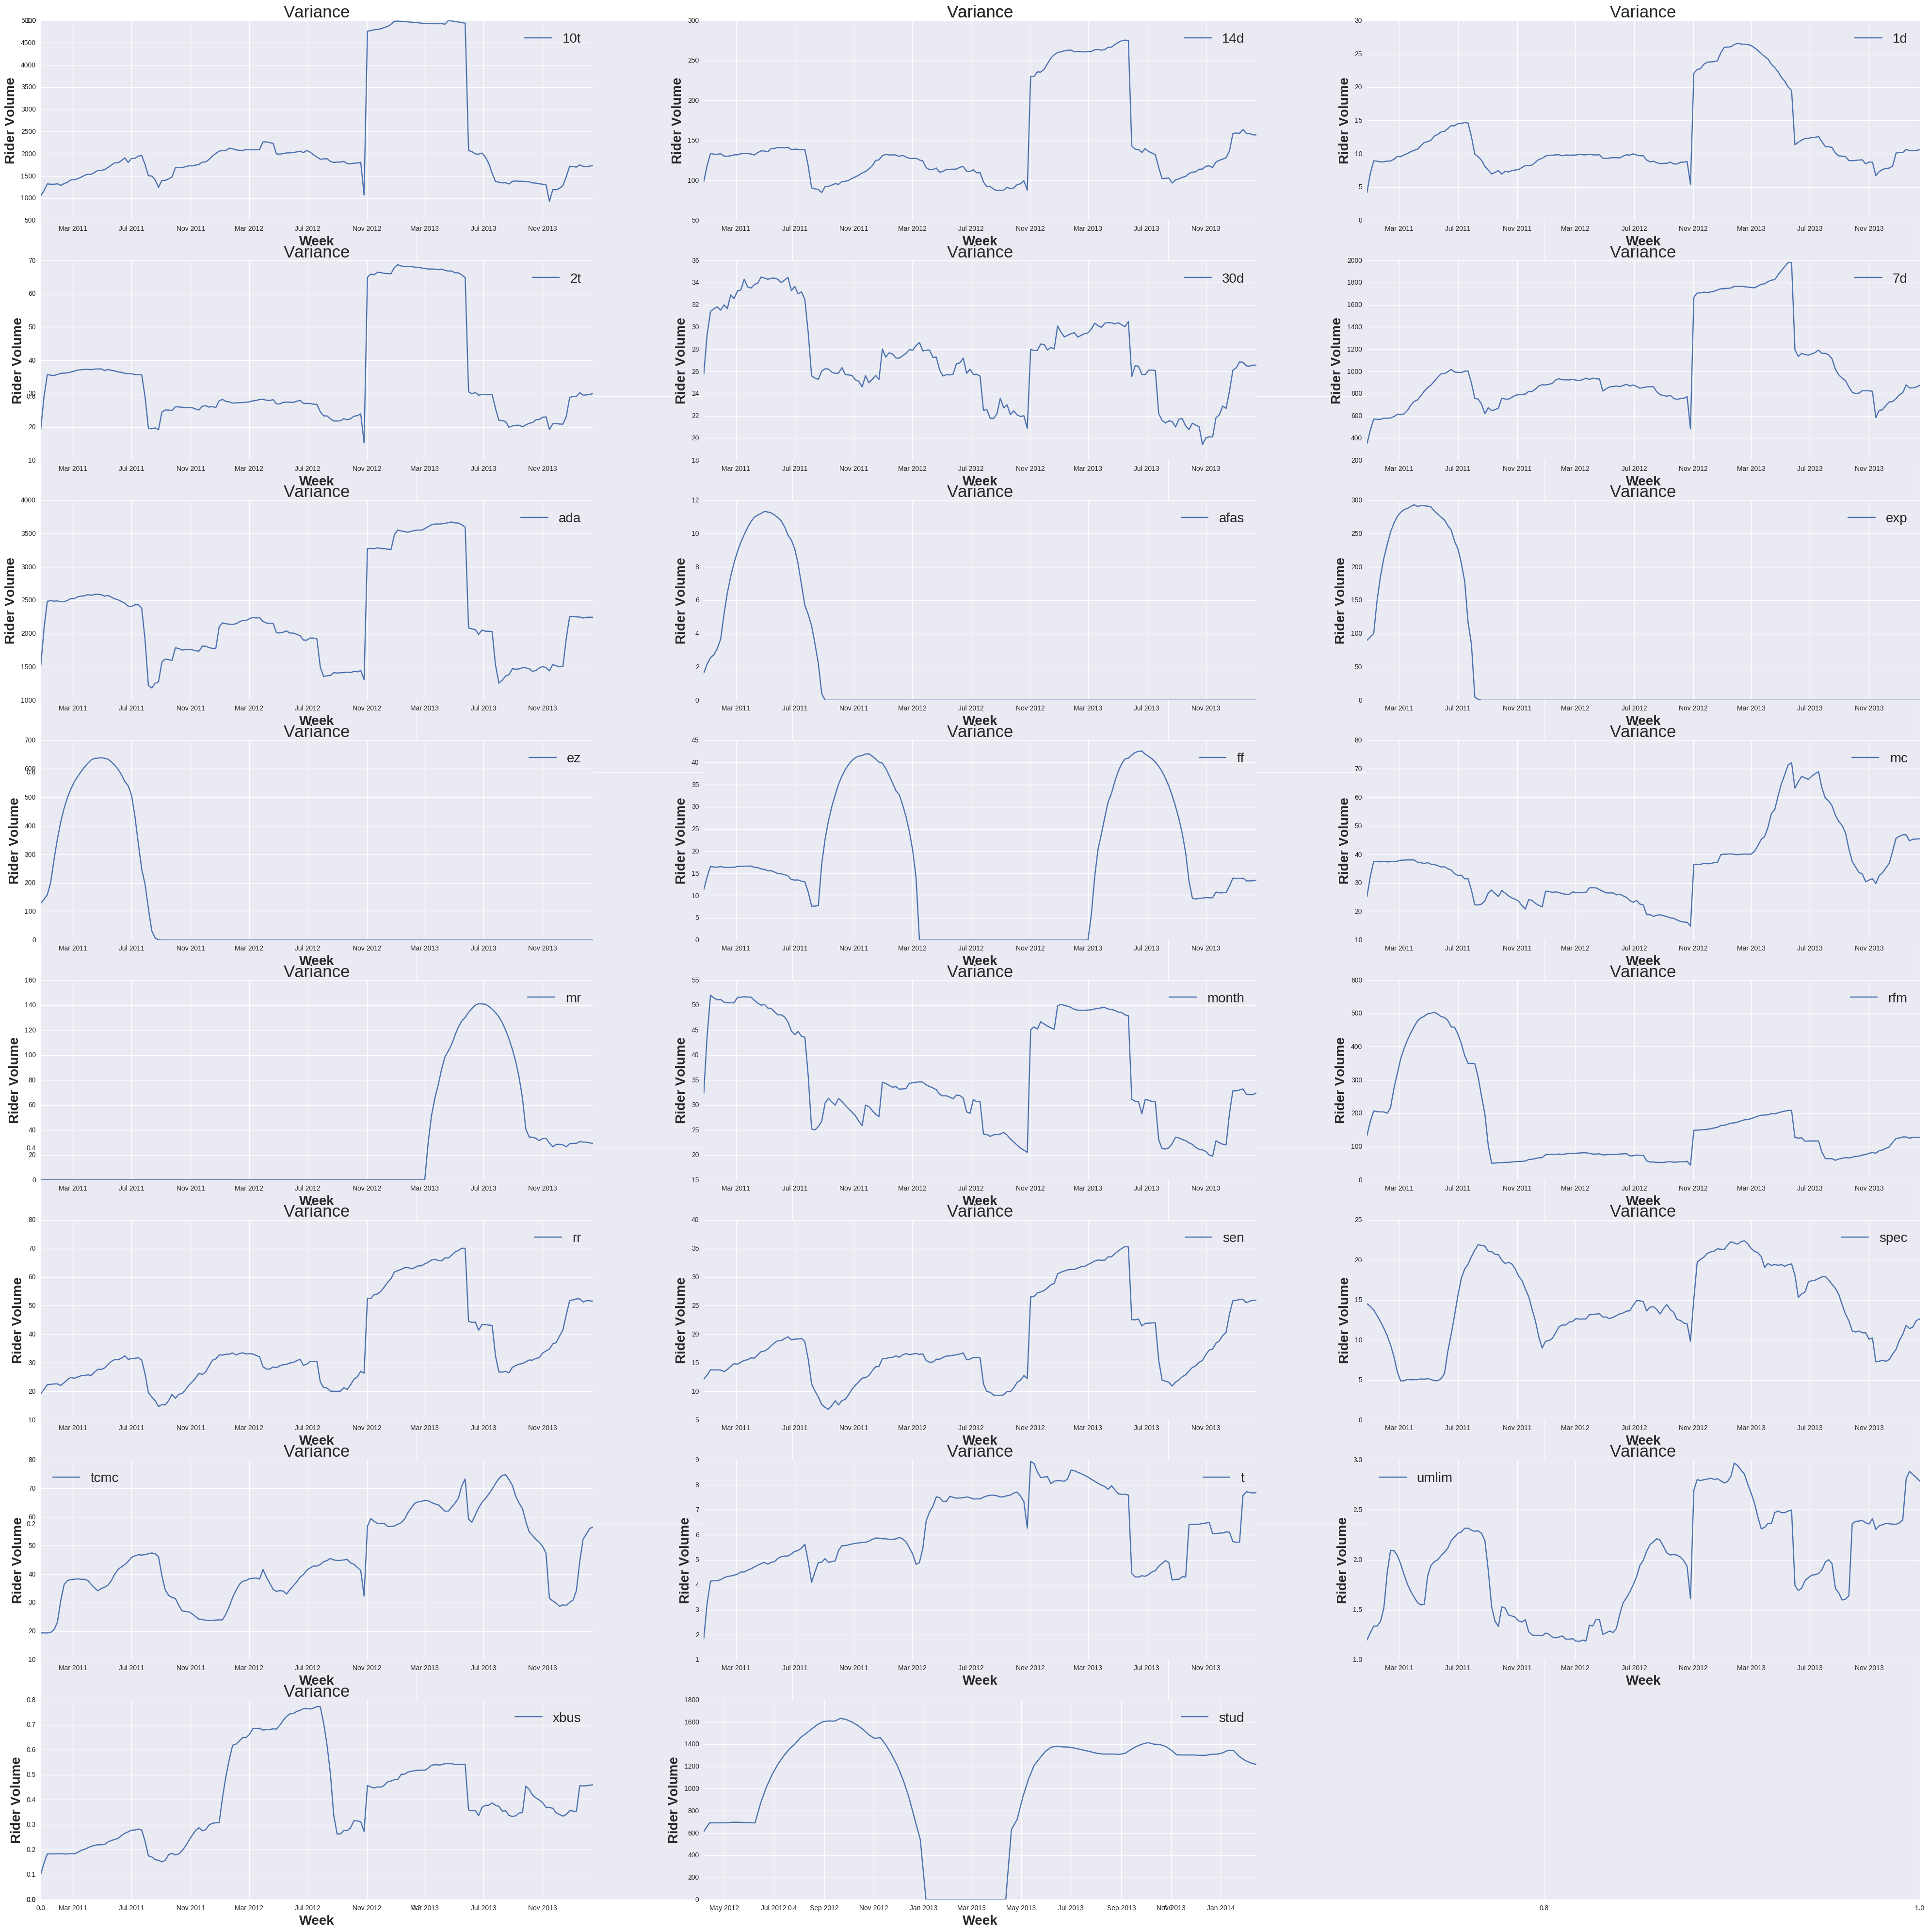

In [104]:
fig = plt.figure(figsize=(50,50)) 
x = 1

for i in ridetype:
    plt.title('Variance',fontsize = 25)
    std1 = pd.rolling_std(MTAD_2[i], 30)
    ax = fig.add_subplot(8,3,x)
    ax.plot(MTAD_2.index,std1)
    pl.xlabel("Week", fontsize=20, fontweight = 'bold')
    pl.ylabel("Rider Volume", fontsize=20, fontweight = 'bold')
    pl.legend([i], fontsize = 20, loc = 'best')
    x = x+1  

#### Figure 8: Rolling Variance for every rider type (Numbered 23).
- This plot confirms the same trends that have been observed in the rolling mean.
- Visually based on the plots above, we can tell that there are trends in certain rider types:
- Increasing population for:
    - 7-day pass('7d')
    - 14-day pass('14d')
    - Rail Road('rr') and 
    - Senior Citizen ('sen') 
- On the other hand, there is a decreasing trend of Monthly Rider ('month').

In [115]:
smoothrides = np.empty_like(mta_data[0])
countratio = np.zeros(len(mta_data[0]), float)
for i in range(mta_data.shape[1]):
    mta_allsum = mta_data[:,i,:]
    
    #rolling mean to smooth structure on short time scales and summing over all stations
    smoothrides[i] = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    countratio[i] = np.nanmean(smoothrides[i][:10])/np.nanmean(smoothrides[i][-10:])
    print ('\n"%s" Rider type \nRatio of: %s \nStandard Deviation: %s' \
           %(ridetype[i],countratio[i],np.nanstd(smoothrides[i])))



"10t" Rider type 
Ratio of: 0.951681784403 
Standard Deviation: 546777.616992

"14d" Rider type 
Ratio of: 0.753056693835 
Standard Deviation: 64593.9013999

"1d" Rider type 
Ratio of: 0.854224343773 
Standard Deviation: 5767.41249418

"2t" Rider type 
Ratio of: 1.02775863514 
Standard Deviation: 8828.00385607

"30d" Rider type 
Ratio of: 0.93477935432 
Standard Deviation: 3624.08852559

"7d" Rider type 
Ratio of: 0.685982250186 
Standard Deviation: 631955.017784

"ada" Rider type 
Ratio of: 1.08592961275 
Standard Deviation: 473487.373171

"afas" Rider type 
Ratio of: 4924.34977578 
Standard Deviation: 3794.92677395

"exp" Rider type 
Ratio of: 94109.1091954 
Standard Deviation: 101444.891854

"ez" Rider type 
Ratio of: 503545.12605 
Standard Deviation: 206370.776156

"ff" Rider type 
Ratio of: 1.15498991569 
Standard Deviation: 18800.9465287

"mc" Rider type 
Ratio of: 0.812339682807 
Standard Deviation: 25371.3235538

"mr" Rider type 
Ratio of: 3.79761339641e-05 
Standard Deviation

#### From the analysis above, it can be observed that:
- Senior passes had a steady increase in usage over that period of time
- Monthly passes had a steady decrease in usage over that period of time

#### ----------------------------------------------------------------------------------------------------------------------------------------------

### Task 3:
#### Several stations show a prominent annual periodicity. Identify the 4 **stations** 
- Identify them by the index of their location in the data cube that show the most prominent periodic trend on an annual period (52 weeks)

#### In this case we look at the day with 600 stations in 194 weeks

In [117]:
MTAData.head(3)

0        1       2        3        4        5        6    \
2010-06-04  126878.0  37306.0  6606.0  16378.0  18564.0  19987.0  12449.0   
2010-06-11  149477.0  46464.0  6881.0  17408.0  19903.0  20625.0  13644.0   
2010-06-18  152383.0  49359.0  7229.0  17595.0  19948.0  21225.0  13719.0   

                7        8         9   ...   590  591  592  593  594  595  \
2010-06-04  11091.0  10482.0  147187.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-11  11659.0  11030.0  154826.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   
2010-06-18  12037.0  10881.0  155958.0 ...   0.0  0.0  0.0  0.0  0.0  0.0   

            596  597  598  599  
2010-06-04  0.0  0.0  0.0  0.0  
2010-06-11  0.0  0.0  0.0  0.0  
2010-06-18  0.0  0.0  0.0  0.0  

[3 rows x 600 columns]

In [121]:
Frequency = 1
Period = 52 * Frequency
Sample_Rate = 1
Duration = 194
N = Duration * Sample_Rate
N #To Check

194

- The absolute value of the Fourier Transform is used for Real Frequencies, where [Real = Positive]. 
- Only the real frequencies by using the np.rfft function (instead of np.fft).
- The real part of the Fourier Transform is obtained by using the absolute value of the Fourier Transform. 
- Or taking the square of the Fourier Transforms of all the Real/Positive Frequencies.
- Moving forward with this the Complex Part of the Fourier Transform is removed.

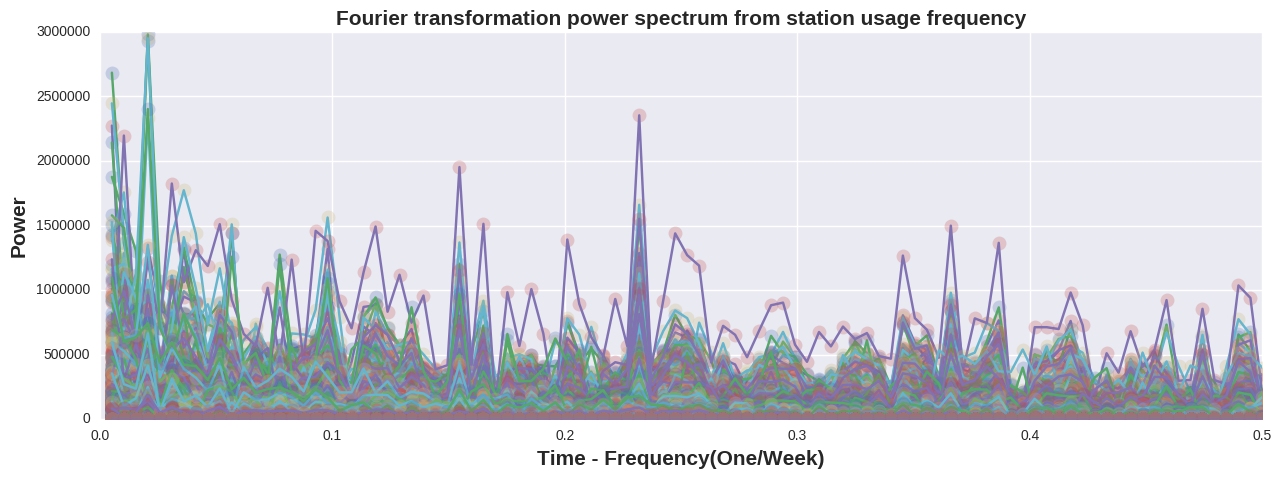

In [139]:
fig=pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)

m = np.arange(0, 599, 1)

for i in m:
    f = np.abs(np.fft.rfft(MTAData[i]))
    
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), 'o', ms=10, alpha = .25)
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:], (f[1:]), '-')
    
    pl.xlabel("Time - Frequency(One/Week)", fontsize=15, fontweight = 'bold')
    pl.ylabel("Power", fontsize=15, fontweight = 'bold')
    pl.title("Fourier transformation power spectrum from station usage frequency", 
             fontsize=15, fontweight = 'bold')

#### Figure 9: Rider Volume Power Spectrum (Numbered 600) 

In [153]:
print ("Periods when the Power is Calculated: \n", 1.0/np.fft.rfftfreq(N, 1.0)[1:])

Periods when the Power is Calculated: 
 [ 194.           97.           64.66666667   48.5          38.8
   32.33333333   27.71428571   24.25         21.55555556   19.4
   17.63636364   16.16666667   14.92307692   13.85714286   12.93333333
   12.125        11.41176471   10.77777778   10.21052632    9.7
    9.23809524    8.81818182    8.43478261    8.08333333    7.76
    7.46153846    7.18518519    6.92857143    6.68965517    6.46666667
    6.25806452    6.0625        5.87878788    5.70588235    5.54285714
    5.38888889    5.24324324    5.10526316    4.97435897    4.85
    4.73170732    4.61904762    4.51162791    4.40909091    4.31111111
    4.2173913     4.12765957    4.04166667    3.95918367    3.88
    3.80392157    3.73076923    3.66037736    3.59259259    3.52727273
    3.46428571    3.40350877    3.34482759    3.28813559    3.23333333
    3.18032787    3.12903226    3.07936508    3.03125       2.98461538
    2.93939394    2.89552239    2.85294118    2.8115942     2.77142857
    2

In [161]:
MTAD_3 = pd.DataFrame(mta1)
p = {}

for i in range(600):
    p[i] = np.abs(np.fft.rfft(MTAD_3.loc[i,:]))[4]
    
dict(sorted(p.items(), key = operator.itemgetter(1), reverse = True)[:4])

{0: 2980160.6355953491,
 150: 2931895.8769513383,
 194: 2950388.929214194,
 327: 2402218.5809588572}

- The stations with the highest yearly periodicity are:
    - Station '0'
    - Station '150'
    - Station '194'
    - Station '327'
- These stations have values between 2.5 and 3 million in the power spectrums as observed above. 
- The higher the value of the power spectrum at a given period, the higher the periodicity of that station at that time.

#### ----------------------------------------------------------------------------------------------------------------------------------------------

### EXTRA CREDIT: Cluster. 
#### Cluster the time series, i.e. identify groups of time series that look similar among each other. 

#### KMeans Clustering
- Code taken from the instructors supplimentary IPython notebook.
- Code also taken from Shalmali Kulkarni.

In [165]:
mta_data = data_MTA.astype(float)
# data_MTA - Initially loaded - and changed to float
# Going through the step again

totals = mta_data.transpose(2,0,1).reshape(mta_data.shape[2], 
                                           mta_data.shape[1] * 
                                           mta_data.shape[0]).T
tots = totals[totals.std(1)>0]
tots

array([[ 3292.,  3429.,  3629., ...,  3746.,  3406.,  3217.],
       [  110.,    92.,   102., ...,   212.,   209.,   211.],
       [    7.,     6.,    13., ...,    26.,    20.,    22.],
       ..., 
       [    0.,     0.,     0., ...,     0.,     0.,     0.],
       [    0.,     0.,     0., ...,  1959.,  1773.,  1667.],
       [  202.,   150.,   135., ...,   213.,   168.,   214.]])

#### Number of Clusters selecting randomly - 10

In [213]:
km = KMeans(n_clusters=10, random_state=555)
vals = ((tots.T - tots.mean(1))/tots.std(1)).T
km.fit(vals)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=10, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=555, tol=0.0001,
    verbose=0)

#### Checking the lables of the clusters

In [218]:
km.labels_

array([5, 6, 1, ..., 3, 6, 7], dtype=int32)

- Distance can be calculated using the "centroids" of the clusters since it is K-Means method.
- This is plotted against the transformed numpy array. 
- This is to justify the distances and "centroids".
- In order to analyze this data further, one would need "MetaData" in regards to the MTA Turnstyle Data.

In [224]:
distance = (np.array([vals - km.cluster_centers_[i] for i in range (len(km.cluster_centers_))])**2)
distance

array([[[  1.79831032e+00,   1.53689382e+00,   5.48043997e-01, ...,
           2.32523347e-02,   8.49442767e-01,   1.65264395e+00],
        [  2.18414583e+00,   4.57725460e+00,   3.69280975e+00, ...,
           7.92295436e-01,   8.47898815e-01,   1.17867199e+00],
        [  4.11616579e+00,   5.76219242e+00,   2.40799481e+00, ...,
           1.12045612e-01,   9.18812465e-02,   3.80069058e-03],
        ..., 
        [  5.72423381e-01,   1.01066050e+00,   1.03405813e+00, ...,
           5.29984463e-01,   3.94999360e-01,   2.59598519e-01],
        [  8.38718957e+00,   9.88972900e+00,   9.96263572e+00, ...,
           1.58163544e-02,   8.21215019e-02,   9.98174394e-02],
        [  2.66659331e-01,   3.19471782e+00,   4.38412248e+00, ...,
           7.37435349e-02,   1.11659949e+00,   1.11600180e-03]],

       [[  1.50627458e-01,   1.11145084e-01,   6.52556955e-01, ...,
           1.92898898e-01,   1.27611025e+00,   2.16998243e+00],
        [  6.31179564e-02,   3.20755077e-01,   1.39546004e-0

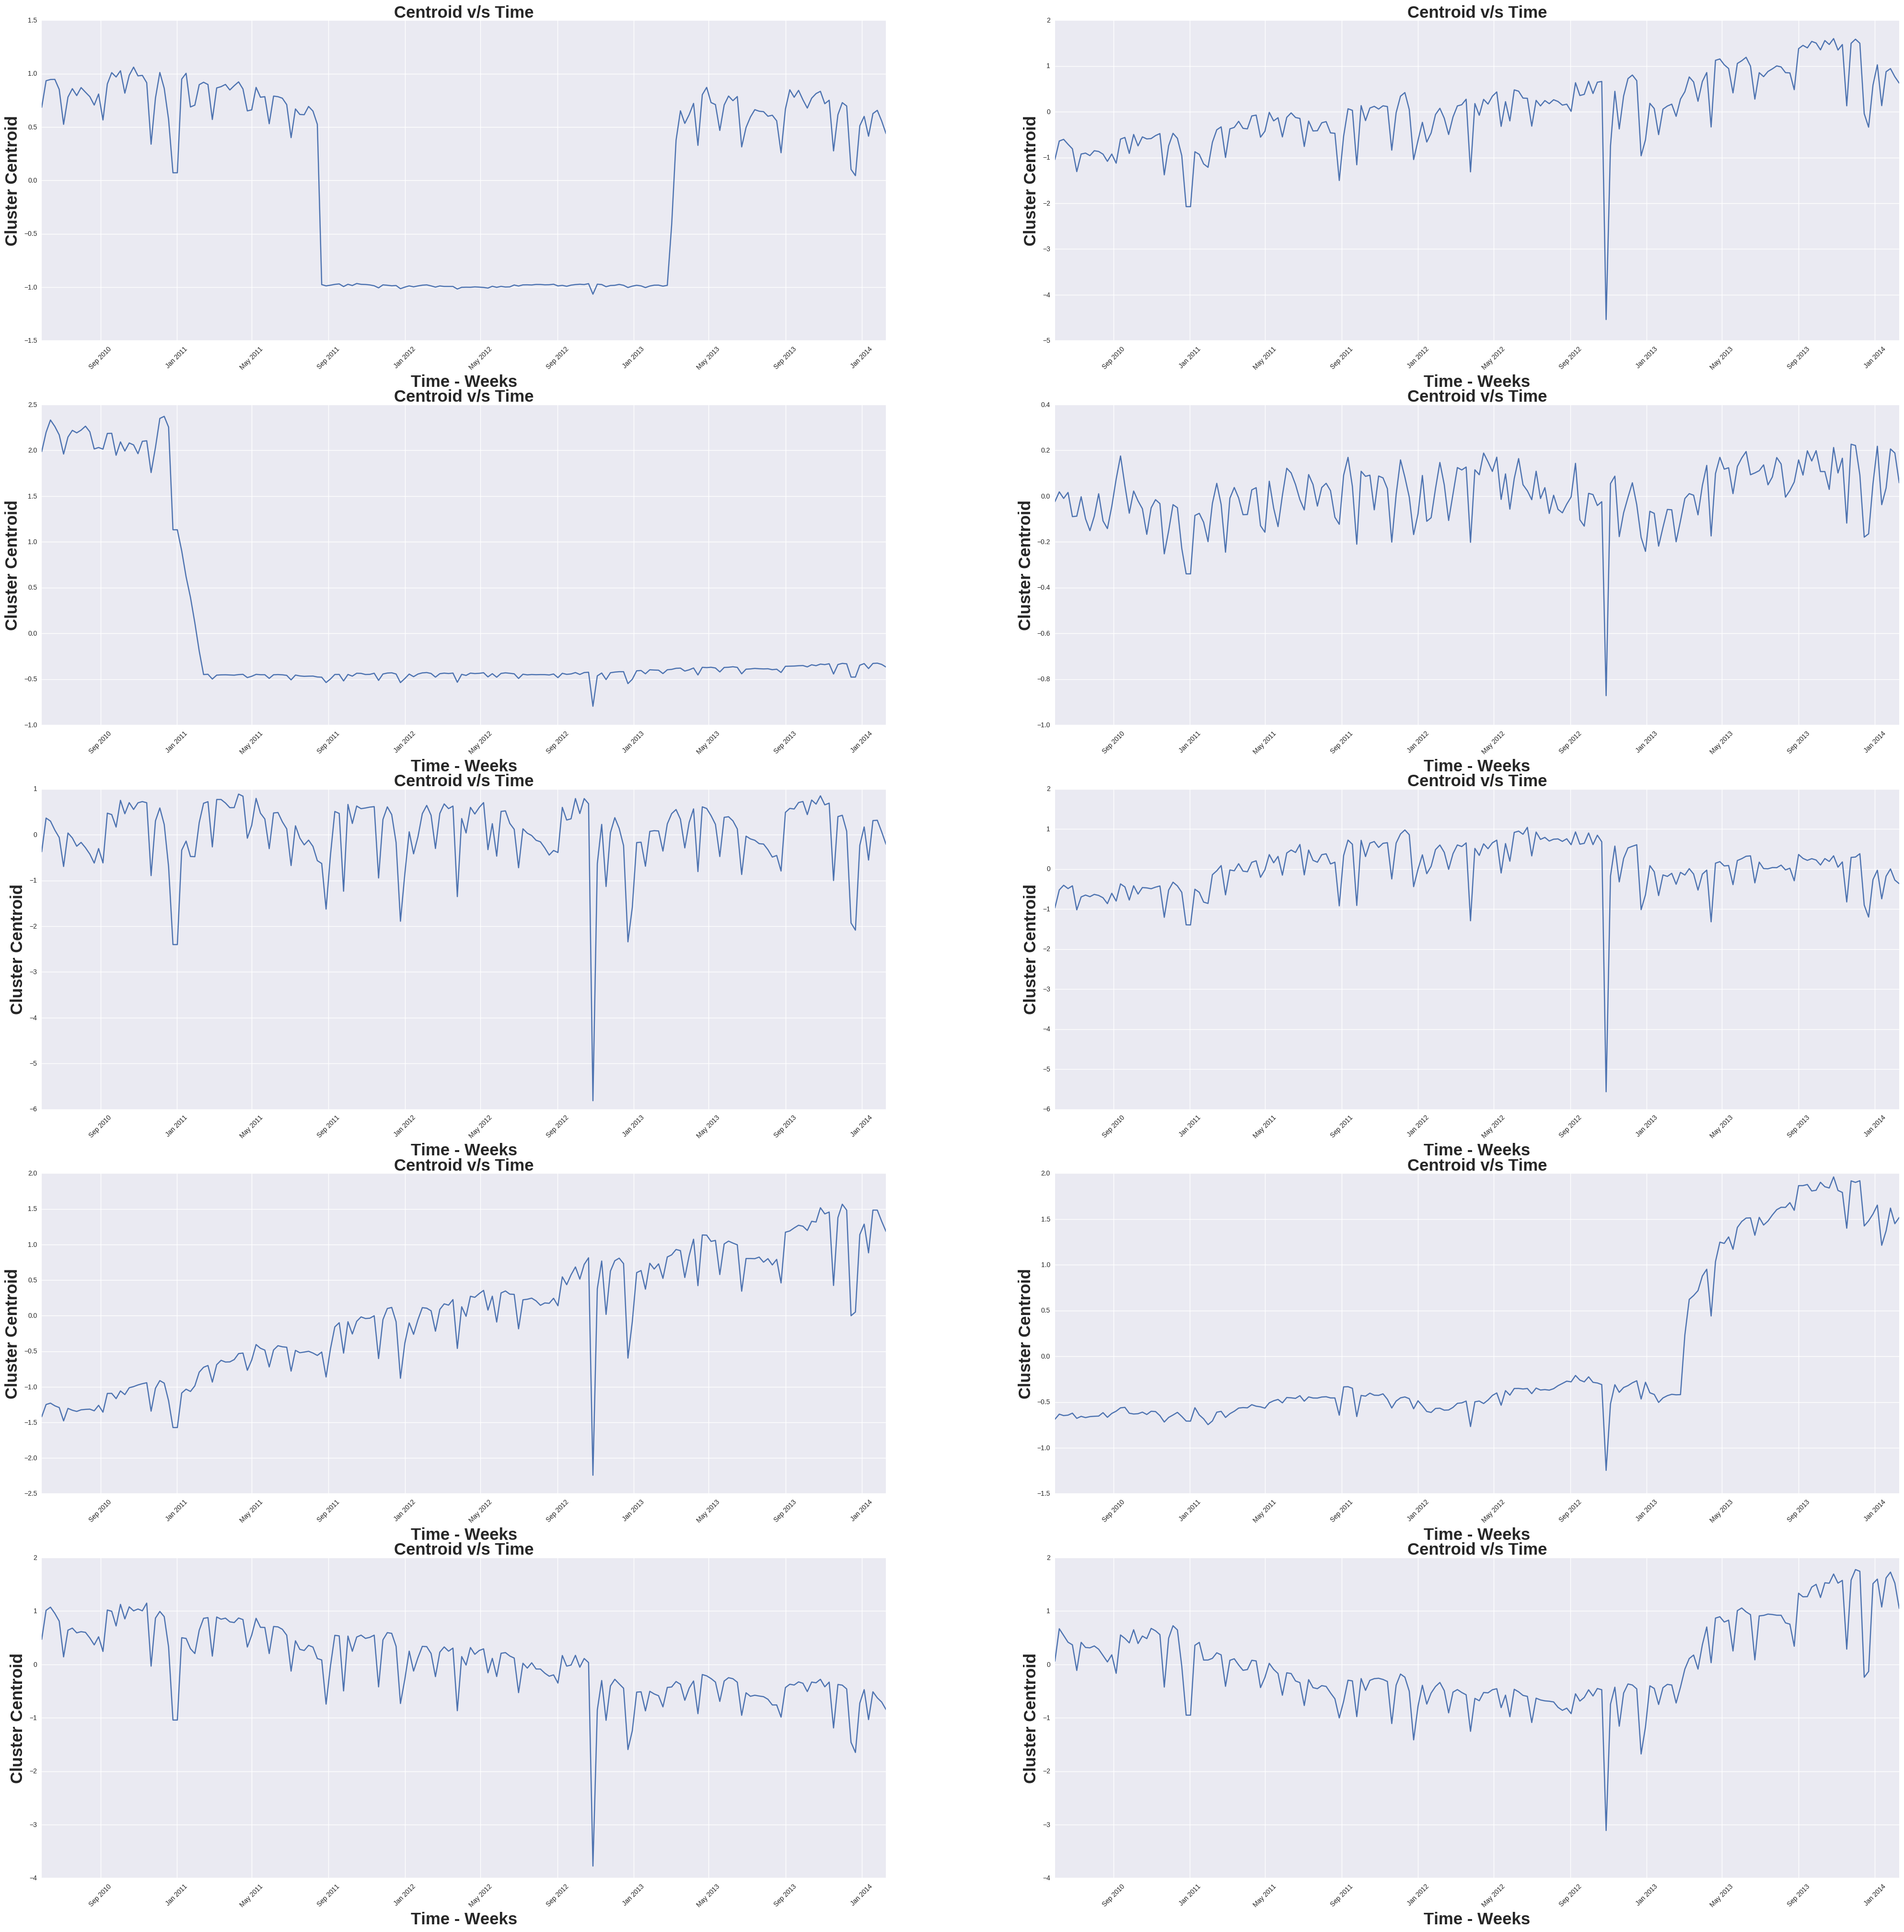

In [240]:
fig = pl.figure(figsize = (50,50))

for i,Xc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(5,2,(i+1))
    ax.plot(rng, Xc)
    pl.xlabel("Time - Weeks", fontsize=25, fontweight = 'bold')
    pl.ylabel("Cluster Centroid", fontsize=25, fontweight = 'bold')
    pl.title("Centroid v/s Time", fontsize=25, fontweight = 'bold')
    pl.xticks(rotation = 45, fontsize = 10)

#### Figure 10: Cluster Centroids and Time-Series.
- Every given 23 types of Rider_Cards have been clustered into 10 clusters. 
- Further data would be required to interept these clusters and trends plotted.

#### ----------------------------------------------------------------------------------------------------------------------------------------------